# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-06 21:31:25--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-06 21:31:26--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M  53.2MB/s    in 0.7s    

2023-12-06 21:31:27 (53.2 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

Разберемся подробнее в устройстве Element Tree:

In [3]:
root = ET.parse('data/xmls/IMG_2384.xml').getroot()
for child in root:
    print(child.tag, child.attrib)

folder {}
filename {}
path {}
source {}
size {}
segmented {}
object {}


In [4]:
print(ET.tostring(root, encoding='utf8').decode('utf8'))

<?xml version='1.0' encoding='utf8'?>
<annotation>
	<folder>test</folder>
	<filename>IMG_2384.JPG</filename>
	<path>C:\tensorflow_cards\test\IMG_2384.JPG</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>378</width>
		<height>504</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>king</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>135</xmin>
			<ymin>203</ymin>
			<xmax>229</xmax>
			<ymax>327</ymax>
		</bndbox>
	</object>
</annotation>


перейдем к заданию:

In [5]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        res =  [int(member.find('bndbox').find('xmin').text),
                int(member.find('bndbox').find('ymin').text),
                int(member.find('bndbox').find('xmax').text),
                int(member.find('bndbox').find('ymax').text),
                class_dict[member.find('name').text]
         ] ### YOUR CODE HERE ###

        bboxes.append(res)

    return bboxes

In [6]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###

        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###

        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [7]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [8]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

In [9]:
test_ds[0]

{'image': tensor([[[-0.1657, -0.1486, -0.1486,  ..., -0.1314, -0.1657, -0.3541],
          [-0.1999, -0.1486, -0.1143,  ..., -0.0972, -0.1828, -0.3198],
          [-0.1657, -0.1314, -0.0972,  ..., -0.1999, -0.2856, -0.3712],
          ...,
          [ 1.6495,  1.6153,  1.6153,  ...,  1.5125,  1.4954,  1.4954],
          [ 1.7009,  1.7180,  1.7009,  ...,  1.5125,  1.5297,  1.5297],
          [ 1.7523,  1.7009,  1.6667,  ...,  1.4954,  1.4954,  1.4954]],
 
         [[-0.9153, -0.8978, -0.8978,  ..., -0.7752, -0.8277, -1.0203],
          [-0.9503, -0.8803, -0.8627,  ..., -0.7577, -0.8452, -0.9853],
          [-0.9678, -0.8978, -0.8452,  ..., -0.8452, -0.9503, -1.0378],
          ...,
          [ 0.7304,  0.6954,  0.6954,  ...,  0.9405,  0.9230,  0.9230],
          [ 0.7479,  0.7654,  0.7479,  ...,  0.9580,  0.9580,  0.9580],
          [ 0.8004,  0.7479,  0.7129,  ...,  0.9405,  0.9230,  0.9230]],
 
         [[-1.2641, -1.2641, -1.2816,  ..., -1.0550, -1.1247, -1.3339],
          [-1.2990,

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [10]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        images[i] = images[i].permute(1, 2, 0)

        images[i][:, :, 0] = images[i][:, :, 0] * std[0] + mean[0]
        images[i][:, :, 1] = images[i][:, :, 1] * std[1] + mean[1]
        images[i][:, :, 2] = images[i][:, :, 2] * std[2] + mean[2]

        ax.imshow(images[i])

        for bbox in bboxes[i]:
          #print(bbox)
          rect = Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='red', facecolor = 'none')
          ax.add_patch(rect)

          ax.text(bbox[0], bbox[1] - 2, s=train_ds.class_dict_inv[int(bbox[4])], c = 'red')
        ### YOUR CODE HERE ###



    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

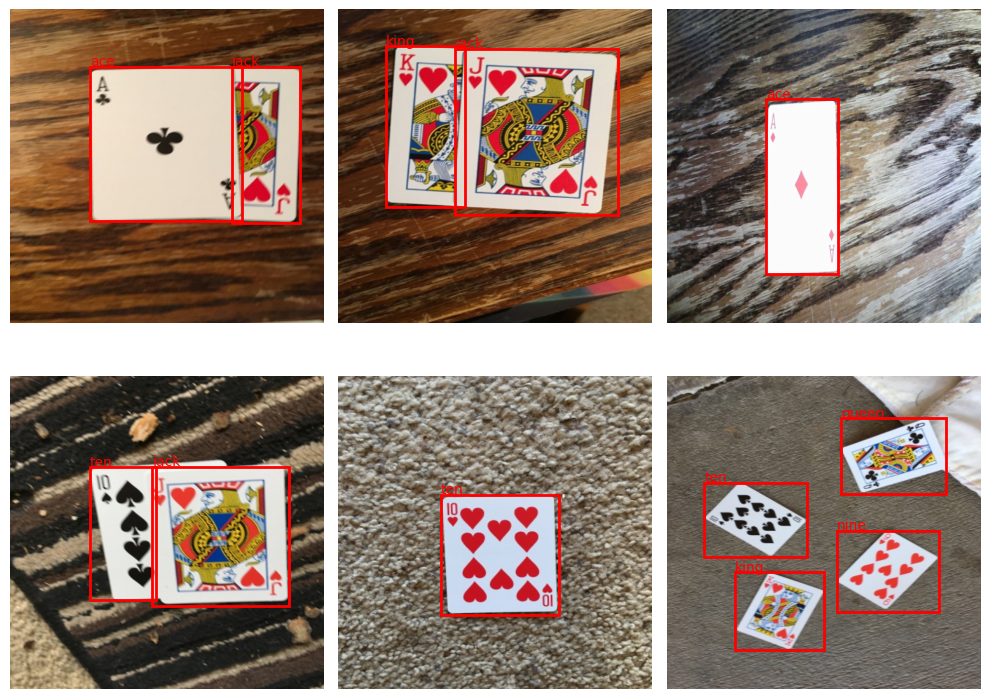

In [11]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [12]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell = downsample # TODO размер клетки по X в пикс
        y_cell =  downsample # TODO размер клетки по Y в пикс
        w_box =  (xmax - xmin) / 512 # TODO ширина бокса отнормированная
        h_box =  (ymax - ymin) / 512 # TODO высота бокса отнормированная

        # Посчитайте координаты центра и сдвиги
        cx =  (xmax + xmin) / 2 # TODO (координаты центра в исходных координатах)
        cy =  (ymax + ymin) / 2 # TODO
        cx_idx =  (cx // x_cell).type('torch.LongTensor') # TODO (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx =  (cy // y_cell).type('torch.LongTensor') # TODO

        cx_box =  (cx - cx_idx * x_cell) / x_cell# TODO (посчитайте сдивиги относительно cx_idx)
        cy_box =  (cy - cy_idx * y_cell) / y_cell # TODO

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

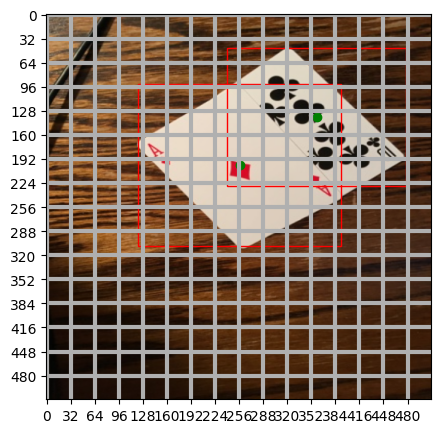

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [15]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    ### YOUR CODE HERE ###

    boxes = []

    if c != 6:
      #inp_max, idx_max = torch.max(pred[:, 5:, :, :].permute(0, 3, 1,2), dim = 2)

      indices = torch.argmax(pred[:, 5:, :, :], dim=1, keepdim=True)

      pred = pred[:, :6, :, :]
      pred[:, 5, :, :] = indices.squeeze(1)

    for el in range(b):
      #проход по клеткам
      el_boxes = []
      for i in range(w):
        for j in range(h):
          part = pred[el, :, j, i]
          if part[4] < threshold:
            pass
          else:
            cx_box = part[0]
            cy_box = part[1]
            width = part[2]
            height = part[3]

            cell_x = upsample * i
            cell_y = upsample * j

            xmin = (upsample * (i + cx_box) * 2 - 512 * width) / 2
            xmax = 512 * width + xmin

            ymin = (upsample * (j + cy_box) * 2 - 512 * height) / 2
            ymax = 512 * height + ymin

            cl = part[5]
            el_boxes.append(torch.stack([xmin, ymin, xmax, ymax, cl]))
      #boxes.append(torch.stack([xmin, ymin, xmax, ymax, cl]))
      boxes.append(el_boxes)

    return boxes

ПРОВЕРИМ СЕБЯ:

In [16]:
batc = [train_ds[i] for i in range(3)]

In [17]:
res = collate_fn(batc)

In [18]:
mask = res['target'][:, 4, :, :] > 0

torch.masked_select(res['target'][:, 5, :, :], mask)

tensor([2., 1., 0., 1., 2.])

In [19]:
decode_prediction(res['target'])

[[tensor([130.0318,  93.4603, 379.2593, 345.3968,   2.0000]),
  tensor([361.6508,  93.4603, 472.7196, 349.4603,   1.0000])],
 [tensor([ 77.2063,  59.9365, 205.8836, 323.0476,   0.0000]),
  tensor([189.6296,  64.0000, 456.4656, 336.2540,   1.0000])],
 [tensor([161.6000, 146.9630, 280.0000, 432.3556,   2.0000])]]

In [20]:
[i['bboxes'] for i in batc]

[[(130.03174603174602,
   93.46031746031746,
   379.25925925925924,
   345.3968253968254,
   2),
  (361.6507936507937,
   93.46031746031746,
   472.7195767195767,
   349.46031746031747,
   1)],
 [(189.62962962962962, 64.0, 456.46560846560845, 336.25396825396825, 1),
  (77.2063492063492,
   59.93650793650794,
   205.88359788359787,
   323.04761904761904,
   0)],
 [(161.6, 146.96296296296296, 280.0, 432.35555555555555, 2)]]

Как видим, декодирование работает верно, отличия в кол-ве знаков после запятой.

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [21]:
torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
with open(str('data') + "/class_dict", "r") as f:
            class_dict = eval(f.readline())
len(class_dict)

6

In [23]:
C =  len(class_dict)# Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        ### YOUR CODE HERE ###
        self.model = torch.nn.Sequential(*list(model.children()))[:-2]
        #self.model = model
        self.conv1 = nn.Conv2d(2048, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(512, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(32, 5 + C, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        ### YOUR CODE HERE ###
        img = self.model(img)
        img = self.relu1(self.bn1(self.conv1(img)))
        img = self.relu2(self.bn2(self.conv2(img)))
        img = self.relu3(self.bn3(self.conv3(img)))
        img = self.sigmoid(self.conv4(img))

        return img

In [24]:
Detector()

Detector(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [25]:
#попробовать меньше, чем 0.1 - многовато

In [26]:
def special_loss(pred, target, check=False, C=C):
    ### YOUR CODE HERE ###
    mask = target[:, 4, :, :] > 0
    #print(mask)
    q, w, r, t = pred.shape
    a = []
    for i in range(C):
      x = pred[:, 5+i, :, :]
      a.append(torch.masked_select(x, mask))
    a = torch.stack(a, dim = 1)

    localization_loss = nn.MSELoss(reduction = 'sum')(torch.masked_select(pred[:, 0, :, :], mask), torch.masked_select(target[:, 0, :, :], mask)) + nn.MSELoss(reduction = 'sum')(torch.masked_select(pred[:, 1, :, :], mask), torch.masked_select(target[:, 1, :, :], mask))
    box_loss = nn.MSELoss(reduction = 'sum')(torch.masked_select(pred[:, 2, :, :], mask).sqrt(), torch.masked_select(target[:, 2, :, :], mask).sqrt()) + nn.MSELoss(reduction = 'sum')(torch.masked_select(pred[:, 3, :, :], mask).sqrt(), torch.masked_select(target[:, 3, :, :], mask).sqrt())

    classification_loss = nn.CrossEntropyLoss(reduction = 'sum')(a, torch.masked_select(target[:, 5, :, :], mask).long())
    confidence_loss = nn.BCELoss(reduction = 'sum')(torch.masked_select(pred[:, 4, :, :], mask), torch.masked_select(target[:, 4, :, :], mask)) + nn.BCELoss(reduction = 'sum')(torch.masked_select(pred[:, 4, :, :], ~mask), torch.masked_select(target[:, 4, :, :], ~mask)) * 0.1

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [27]:
print(special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3))

(tensor(5120.), tensor(5120.), tensor(2812.4465), tensor(256000.))


In [28]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [29]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  15 # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        ### YOUR CODE HERE ###
        image = batch['image'].to(device)
        target = batch['target'].to(device)

        pred = model(image)
        loss = special_loss(pred, target)
        loss.backward()
        opt.step()
        opt.zero_grad()

        epoch_losses.append(loss.cpu().data)

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 99.953;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 45.282;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 38.569;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 33.837;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 31.349;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 29.343;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 27.561;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 28.079;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 26.479;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 25.620;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 25.613;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 25.955;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 25.212;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 25.020;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 24.096;


Запустим обученный детектор на тестовых изображениях:

In [31]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [32]:
# Нужно сделать предсказание и переложить результат на cpu
preds = model(batch['image'].to(device)).cpu().data
### YOUR CODE HERE ###

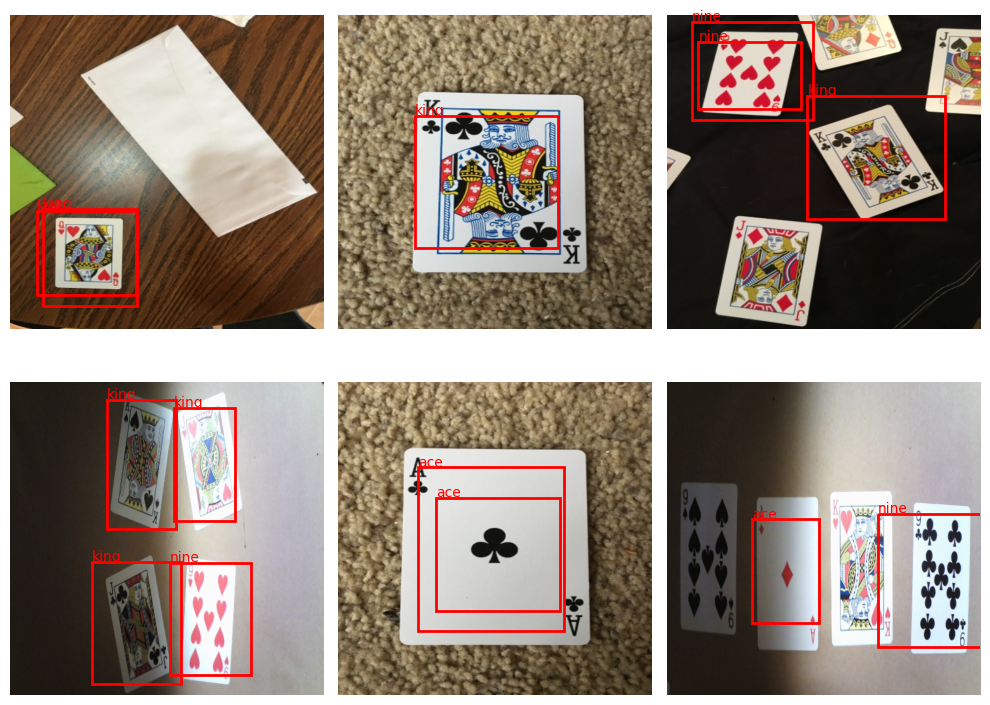

In [33]:
visualize([o for o in batch['image']], decode_prediction(preds))

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [34]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 6.6 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [35]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [36]:
train_ds.__get_raw_item__(0)[1]

[[96, 92, 280, 340, 2], [267, 92, 349, 344, 1]]

In [37]:
def annotation2txt(bboxes, w_im, h_im):
    ### YOUR CODE HERE ###
    string = ''
    s = []
    for bbox in bboxes:
      string =  ' '.join(str(l) for l in [bbox[4],  (bbox[2] + bbox[0]) / 2 / w_im, (bbox[3] + bbox[1]) / 2 / h_im, (bbox[2] - bbox[0]) / w_im, (bbox[3] + bbox[1]) / h_im])
      s.append(string)

    return s

In [38]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [39]:
# Собираем YAML

nc = len(class_dict) # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = list(class_dict.keys()) # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [40]:
import ultralytics
model = ultralytics.YOLO('yolov8n.yaml')
model.train(data='data.yaml', epochs=100)

### YOUR CODE HERE ###


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 5.13MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 25.0MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 245 corrupt: 100%|██████████| 326/326 [00:00<00:00, 2345.41it/s]

train: WARNING ⚠️ /content/train/images/IMG_2384.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0516]
train: WARNING ⚠️ /content/train/images/IMG_2385.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0536]
train: WARNING ⚠️ /content/train/images/IMG_2386.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0099]
train: WARNING ⚠️ /content/train/images/IMG_2387.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0238]
train: WARNING ⚠️ /content/train/images/IMG_2388.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2421]
train: WARNING ⚠️ /content/train/images/IMG_2389.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1687]
train: WARNING ⚠️ /content/train/images/IMG_2390.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1369]
train:


val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 33 corrupt: 100%|██████████| 37/37 [00:00<00:00, 2129.59it/s]

val: WARNING ⚠️ /content/valid/images/IMG_2406.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1389]
val: WARNING ⚠️ /content/valid/images/IMG_2416.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.131]
val: WARNING ⚠️ /content/valid/images/IMG_2426.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4583]
val: WARNING ⚠️ /content/valid/images/IMG_2432.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2163]
val: WARNING ⚠️ /content/valid/images/IMG_2434.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.623]
val: WARNING ⚠️ /content/valid/images/IMG_2440.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4206]
val: WARNING ⚠️ /content/valid/images/IMG_2449.JPG: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.504]
val: WARNING ⚠️ /con

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.79G      3.612      4.586       4.39          6        640: 100%|██████████| 6/6 [00:03<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all          4          5   0.000762      0.125    0.00108   0.000287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.75G      3.675      4.777      4.337          1        640: 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all          4          5    0.00209      0.375     0.0057    0.00137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.75G      3.264      4.427      4.278          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.08it/s]

                   all          4          5    0.00225      0.375    0.00588     0.0022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.74G      3.541      4.465      4.143          3        640: 100%|██████████| 6/6 [00:01<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all          4          5    0.00169      0.375    0.00312   0.000894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.74G      3.287      4.487      4.132          1        640: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all          4          5    0.00158      0.375    0.00165    0.00102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.74G      3.064      4.328      4.078          5        640: 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all          4          5    0.00157      0.375    0.00528    0.00155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.74G      2.936      4.168      3.975          6        640: 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


                   all          4          5    0.00272      0.625    0.00339   0.000728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.74G      2.977      4.252      3.861          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all          4          5    0.00163      0.375    0.00188   0.000484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.75G       2.91      4.191       3.84          2        640: 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all          4          5    0.00161      0.375     0.0015   0.000389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.75G      2.917      3.932      3.674          3        640: 100%|██████████| 6/6 [00:01<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

                   all          4          5    0.00162      0.375    0.00235   0.000621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.75G       2.83      4.072      3.797          2        640: 100%|██████████| 6/6 [00:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all          4          5    0.00163      0.375    0.00299   0.000804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.75G      2.825      4.044      3.668          5        640: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all          4          5    0.00165      0.375    0.00306   0.000816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.75G      2.808      3.843       3.52          5        640: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all          4          5    0.00167      0.375    0.00229   0.000575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.75G      2.722      3.922      3.538          8        640: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


                   all          4          5   0.000825      0.125    0.00108   0.000195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.75G      2.634      3.816      3.443          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


                   all          4          5    0.00164       0.25    0.00348   0.000868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.73G      2.738       3.82      3.546          7        640: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]

                   all          4          5    0.00249       0.25      0.132      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.75G      2.656      3.681      3.303          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all          4          5    0.00442        0.5      0.135      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.75G      2.552      3.858      3.416          3        640: 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

                   all          4          5     0.0064       0.75     0.0946     0.0374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.75G      2.605      4.012      3.275          1        640: 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all          4          5       0.27       0.25     0.0695     0.0297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.75G      2.644      3.655      3.283          4        640: 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]

                   all          4          5      0.522       0.25      0.125     0.0513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.76G      2.725      3.596      3.277          4        640: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


                   all          4          5      0.295       0.25     0.0977     0.0523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.75G      2.597      3.565      3.264          5        640: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all          4          5    0.00559       0.75      0.146     0.0943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.75G      2.585      3.676      3.248          4        640: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


                   all          4          5     0.0627        0.5      0.196     0.0954

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.75G       2.52      3.723      3.162          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


                   all          4          5      0.403      0.375      0.192      0.079

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.75G      2.512      3.643      3.132          3        640: 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all          4          5      0.037        0.5      0.176     0.0767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.75G      2.498      3.806      3.296          2        640: 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]

                   all          4          5     0.0368      0.125     0.0832     0.0364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.75G      2.572      3.706      3.127          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all          4          5      0.449      0.125      0.154     0.0729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.75G      2.493      3.561      3.061          9        640: 100%|██████████| 6/6 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]

                   all          4          5      0.189      0.125      0.177     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.75G       2.39      3.406       3.02          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all          4          5      0.109      0.125      0.152     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.75G      2.648      3.754      3.161          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all          4          5      0.683      0.125      0.235      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.75G      2.397      3.599      2.953          4        640: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


                   all          4          5       0.72      0.125      0.202      0.094

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.75G      2.772      3.639      3.171          3        640: 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all          4          5     0.0445        0.5      0.121       0.04



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.75G      2.483      3.539      2.988          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


                   all          4          5     0.0533       0.25      0.142     0.0703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.75G      2.414      3.743      3.066          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all          4          5     0.0766        0.5      0.271      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.75G      2.398       3.46      2.922          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


                   all          4          5      0.336      0.467      0.233     0.0942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.76G      2.558      3.499      3.081          6        640: 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all          4          5      0.308        0.5      0.181      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.75G      2.393      3.335      2.936          5        640: 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all          4          5      0.789       0.25      0.292     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.75G      2.262       3.49      2.823          1        640: 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


                   all          4          5      0.866       0.25       0.48      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.77G      2.236      3.337      2.824          3        640: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all          4          5      0.847       0.25      0.277     0.0954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.75G      2.391      3.538      2.987          2        640: 100%|██████████| 6/6 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all          4          5      0.799       0.25      0.306      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.75G      2.495      3.541      2.935          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


                   all          4          5      0.517       0.25      0.393      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.75G      2.201      3.201      2.833          6        640: 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all          4          5     0.0921      0.375      0.473      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.75G      2.203      3.179      2.756          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all          4          5      0.485      0.474      0.433      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.75G      2.072       3.46       2.69          1        640: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all          4          5      0.453      0.375      0.357      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.75G      2.378       3.23      2.794          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all          4          5      0.405      0.375      0.473      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.75G      2.246      3.174      2.808          5        640: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


                   all          4          5     0.0073          1      0.352      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.75G      2.137      3.192      2.737          2        640: 100%|██████████| 6/6 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all          4          5      0.103       0.75      0.346       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.75G      2.278      3.164      2.726          4        640: 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


                   all          4          5      0.174       0.75      0.329      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.75G      2.292      3.231      2.852          4        640: 100%|██████████| 6/6 [00:01<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


                   all          4          5      0.137       0.75      0.405       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.78G      2.083      3.098      2.703          4        640: 100%|██████████| 6/6 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]

                   all          4          5      0.504      0.593      0.408      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.75G      2.211      3.385      2.885          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all          4          5      0.465      0.375      0.507      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.78G       2.25       3.37      2.776          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all          4          5      0.461      0.375       0.63      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.75G      2.179      3.049      2.704          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all          4          5      0.413       0.75      0.464      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.75G      2.069      3.246       2.64          1        640: 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


                   all          4          5       0.75      0.235      0.401      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.75G      2.122       2.98      2.703          7        640: 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


                   all          4          5      0.127      0.522      0.373      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.75G      2.155      3.166      2.753          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.58it/s]

                   all          4          5      0.748        0.5      0.552      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.75G       2.14      3.119      2.803          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]

                   all          4          5      0.753        0.5      0.469      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.75G      2.232      3.076       2.68          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all          4          5      0.461      0.375      0.477      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.75G      2.032      2.877      2.557          4        640: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]

                   all          4          5      0.583      0.742       0.56      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.75G      2.124      2.942      2.626          4        640: 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

                   all          4          5      0.644       0.75      0.788      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.75G      1.934       2.87      2.536          2        640: 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

                   all          4          5      0.627      0.701      0.829      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.75G      2.153      2.893      2.547          4        640: 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all          4          5      0.566      0.534      0.829      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.75G      2.175      3.002      2.623          4        640: 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all          4          5      0.467      0.834      0.829       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.75G      2.116      2.838      2.496          4        640: 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all          4          5      0.171          1      0.444      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.75G      1.981      2.964      2.533          1        640: 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]

                   all          4          5      0.215          1      0.497      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.75G      2.004       2.89      2.601          5        640: 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


                   all          4          5       0.39      0.125       0.34      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.75G      2.081      2.901      2.588          3        640: 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all          4          5      0.623      0.375      0.362      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.75G      2.076      3.057      2.654          1        640: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all          4          5      0.796      0.375      0.439       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.75G      2.142      2.941      2.664          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all          4          5      0.739      0.375      0.476      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.78G      1.961      2.824      2.577          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


                   all          4          5      0.265       0.81      0.506      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.75G      1.865      2.831      2.453          1        640: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all          4          5      0.311      0.892      0.497      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.75G      2.084      2.845      2.464          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all          4          5      0.434       0.75      0.611      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.75G      1.977      2.756      2.505          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.97it/s]

                   all          4          5      0.474      0.739      0.608      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.75G      1.938        2.8      2.489          5        640: 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


                   all          4          5      0.608      0.625      0.705      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.75G      1.938      2.794      2.496          5        640: 100%|██████████| 6/6 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all          4          5      0.505      0.693      0.684       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.75G      2.035      2.744      2.477          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


                   all          4          5        0.6      0.667      0.767      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.75G      1.841      2.601      2.493          5        640: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all          4          5      0.583      0.628      0.746      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.75G      1.809      2.813      2.465          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all          4          5      0.551          1      0.808      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.75G       2.04      2.693      2.534          3        640: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all          4          5      0.531       0.75      0.796      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.75G      1.926      2.677      2.441          5        640: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


                   all          4          5      0.566       0.75      0.733      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.75G      2.019      2.908       2.64          1        640: 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


                   all          4          5       0.58       0.75      0.767      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.75G      2.021      2.726      2.572          4        640: 100%|██████████| 6/6 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


                   all          4          5      0.596       0.75      0.787      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.75G      1.907      2.678      2.489          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


                   all          4          5      0.596          1      0.829      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.75G      1.887      2.813      2.466          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]

                   all          4          5      0.582          1      0.787      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.75G      2.041      2.661      2.547          7        640: 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all          4          5      0.554          1      0.808      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.76G      1.889      2.828      2.483          4        640: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all          4          5      0.495          1      0.871      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.75G      1.872      2.736      2.448          5        640: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all          4          5      0.486          1      0.746      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.75G      1.827      2.738      2.483          3        640: 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all          4          5      0.495          1      0.767      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.75G      1.954      2.609      2.387          3        640: 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all          4          5      0.623      0.994      0.829      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.75G      1.814      2.768      2.351          1        640: 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all          4          5      0.639          1      0.829      0.548


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.87G      1.695       2.57      2.306          3        640: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


                   all          4          5      0.506          1      0.829      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.74G      1.628       2.55      2.245          3        640: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all          4          5      0.345          1      0.705       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.74G      1.515      2.662      2.167          1        640: 100%|██████████| 6/6 [00:01<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


                   all          4          5      0.359          1      0.705      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.74G      1.533      2.645      2.208          1        640: 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

                   all          4          5      0.861      0.492      0.705      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.74G      1.571      2.713       2.19          1        640: 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all          4          5      0.843      0.491      0.705      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.74G      1.478      2.434      2.174          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all          4          5      0.472       0.75      0.871      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.74G      1.665      2.797      2.263          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all          4          5      0.588       0.75      0.953      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.74G      1.756      2.643      2.447          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all          4          5      0.639       0.75      0.808      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.74G      1.482      2.296      2.189          2        640: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all          4          5      0.647       0.75      0.808      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.74G      1.415      2.456       2.12          1        640: 100%|██████████| 6/6 [00:01<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]

                   all          4          5      0.512          1      0.746      0.407



100 epochs completed in 0.058 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


                   all          4          5      0.586       0.75      0.953      0.617
                  king          4          1          1          0      0.995      0.501
                   ace          4          1      0.706          1      0.995      0.431
                   ten          4          1      0.207          1      0.995      0.895
                  nine          4          2      0.432          1      0.828      0.641
Speed: 1.3ms preprocess, 6.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f0026999e70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [43]:
### YOUR CODE HERE ###
results = model.predict('valid/images/*.JPG', save = True, project="xxx3", name="yyy1", conf = .25)


image 1/30 /content/valid/images/IMG_2406.JPG: 640x480 1 ten, 35.1ms
image 2/30 /content/valid/images/IMG_2416.JPG: 640x480 1 nine, 21.5ms
image 3/30 /content/valid/images/IMG_2426.JPG: 640x480 1 jack, 18.7ms
image 4/30 /content/valid/images/IMG_2432.JPG: 640x480 1 ten, 1 nine, 31.5ms
image 5/30 /content/valid/images/IMG_2434.JPG: 640x480 (no detections), 12.1ms
image 6/30 /content/valid/images/IMG_2440.JPG: 640x480 1 king, 1 jack, 22.8ms
image 7/30 /content/valid/images/IMG_2449.JPG: 640x480 1 nine, 14.0ms
image 8/30 /content/valid/images/IMG_2456.JPG: 640x480 1 ten, 1 nine, 13.7ms
image 9/30 /content/valid/images/IMG_2457.JPG: 640x480 1 jack, 13.3ms
image 10/30 /content/valid/images/IMG_2461.JPG: 640x480 1 ten, 12.9ms
image 11/30 /content/valid/images/IMG_2472.JPG: 640x480 1 nine, 16.4ms
image 12/30 /content/valid/images/IMG_2488.JPG: 640x480 1 jack, 13.0ms
image 13/30 /content/valid/images/IMG_2497.JPG: 640x480 1 jack, 11.7ms
image 14/30 /content/valid/images/IMG_2524.JPG: 640x480 

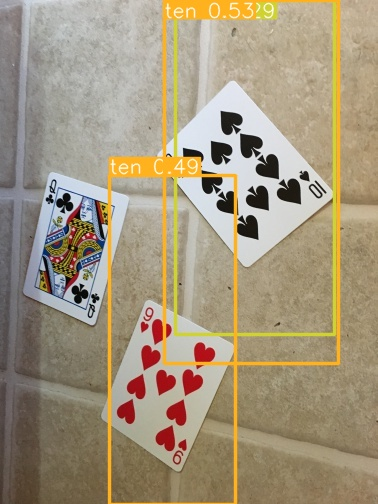

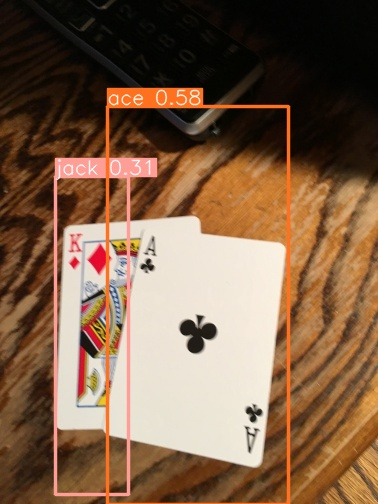

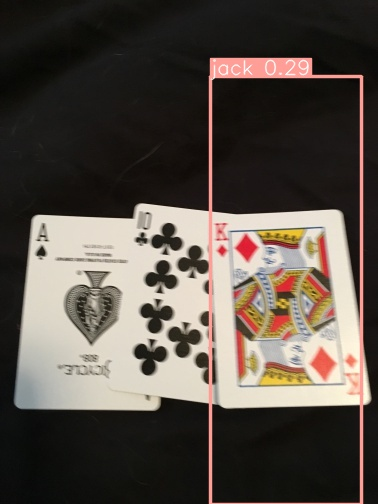

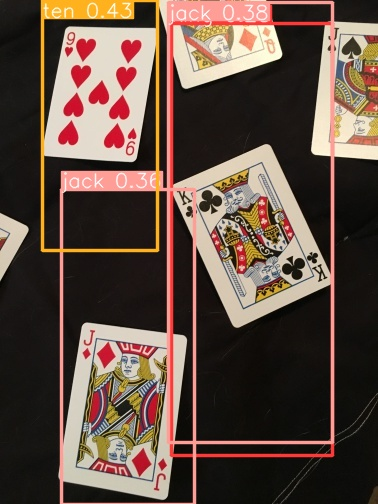

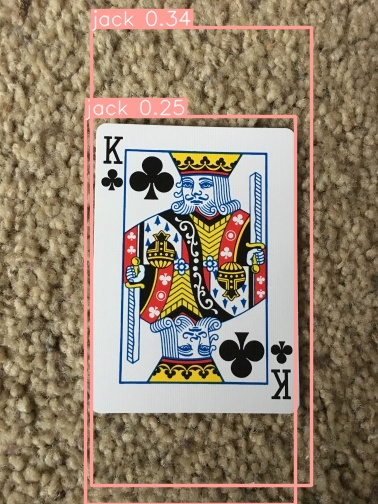

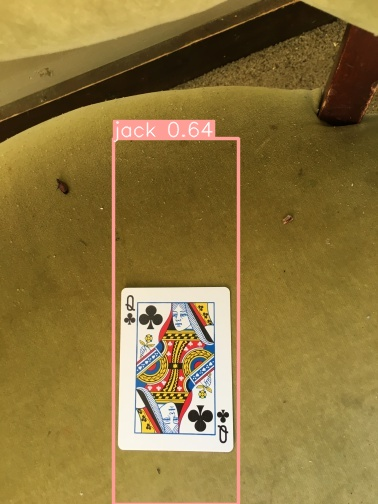

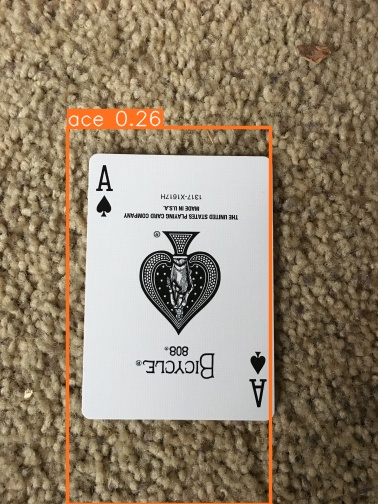

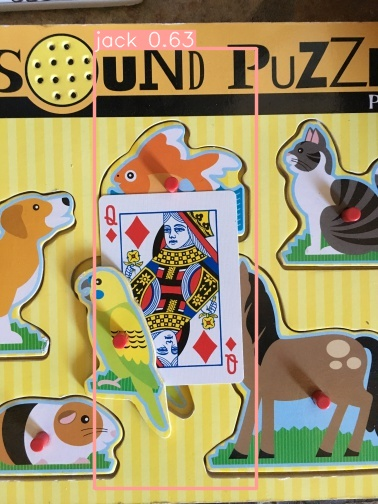

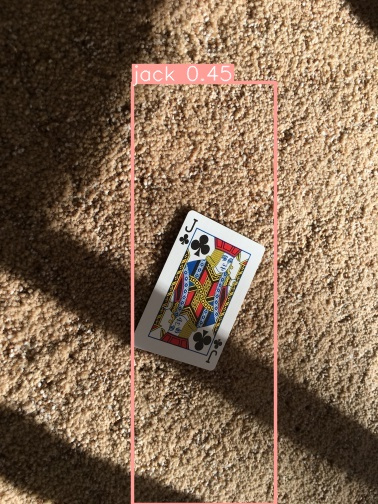

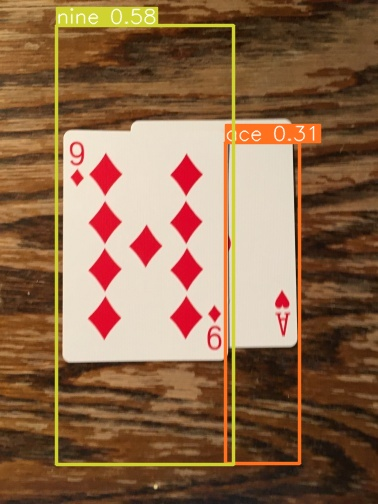

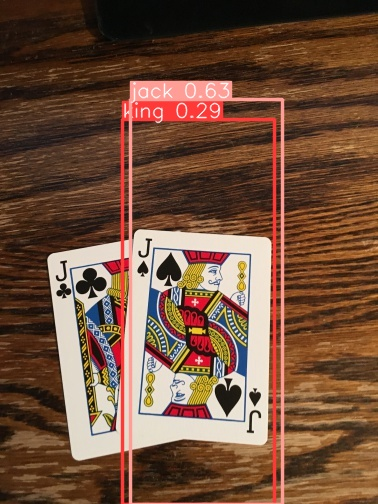

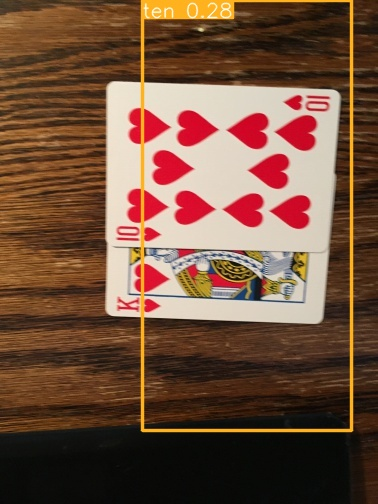

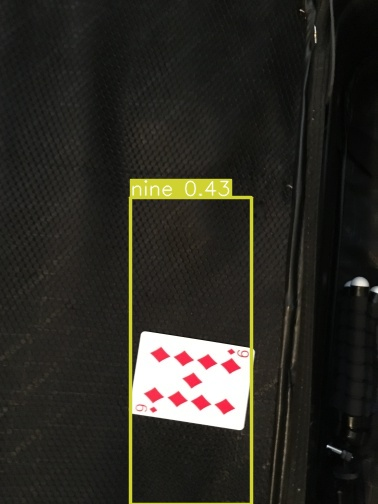

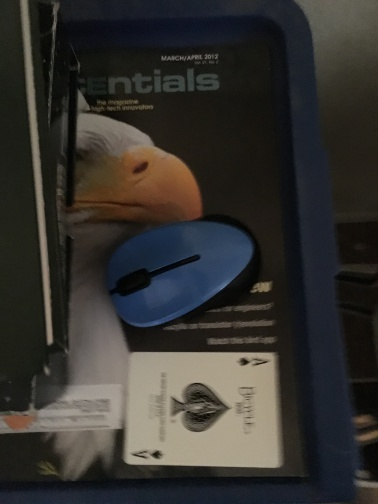

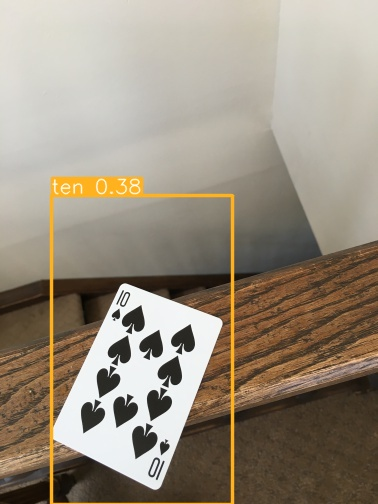

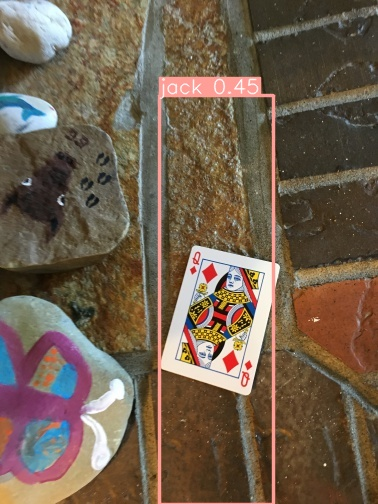

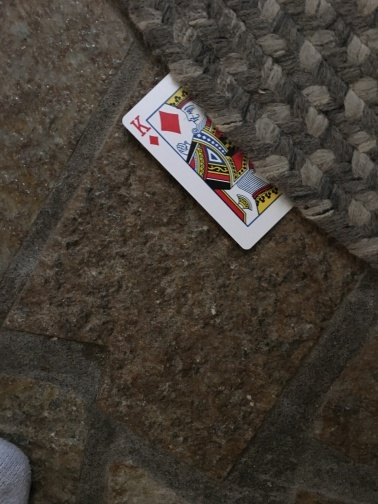

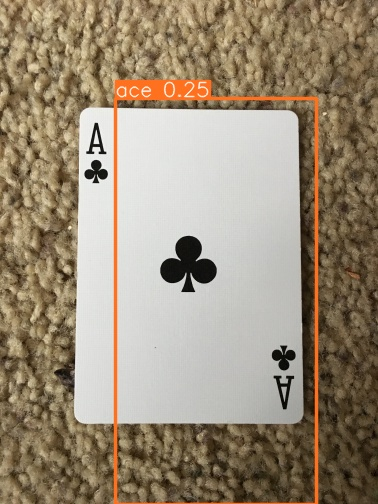

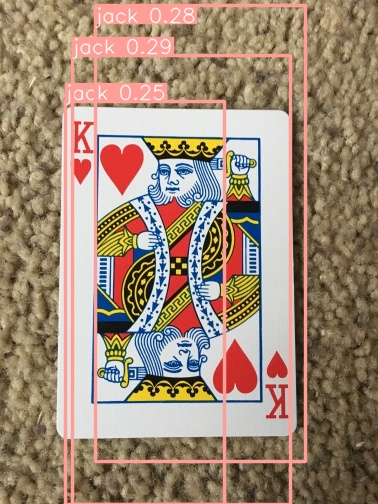

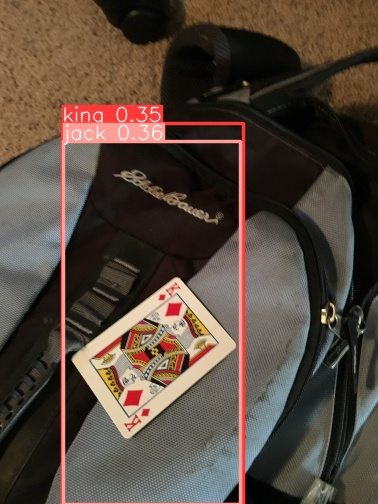

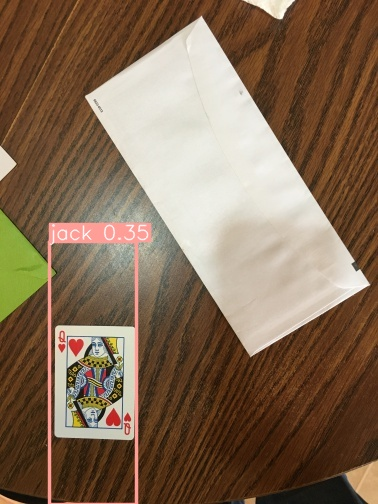

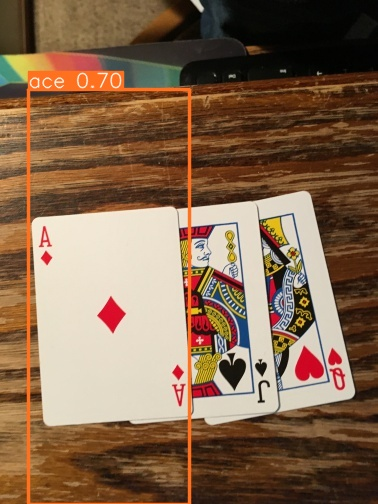

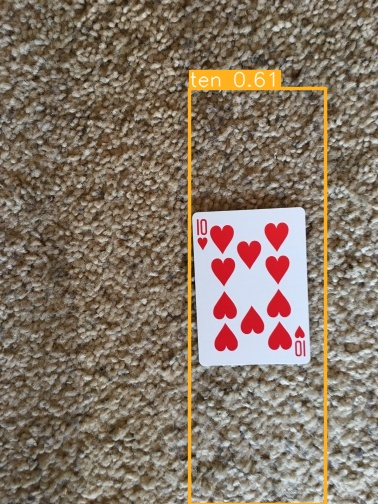

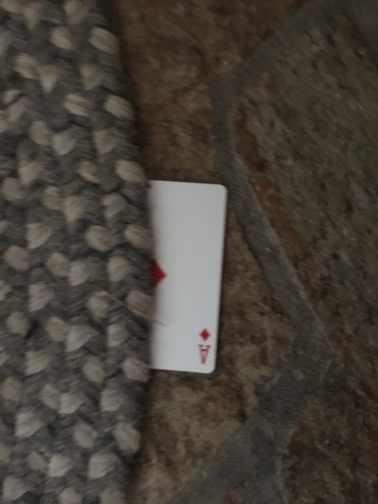

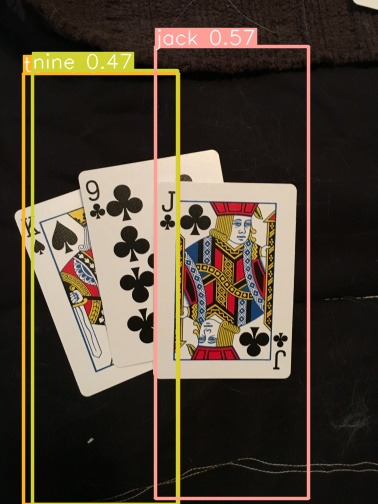

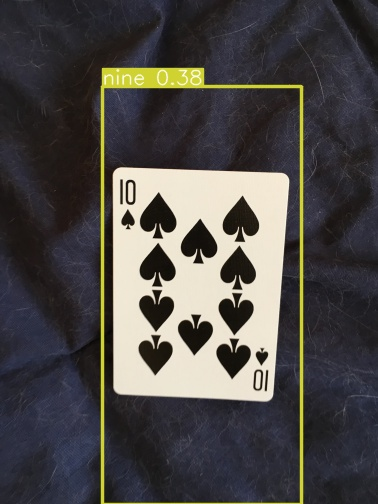

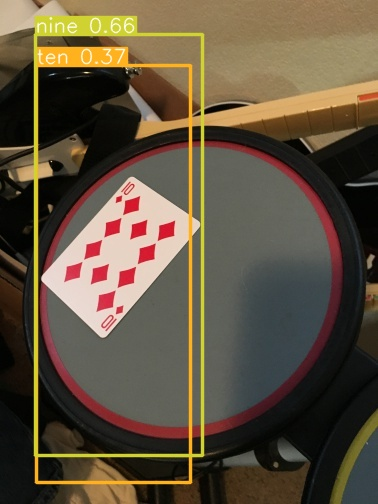

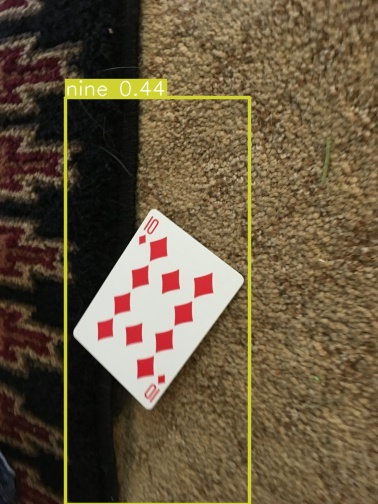

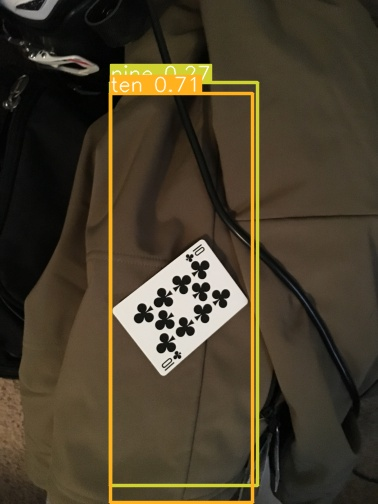

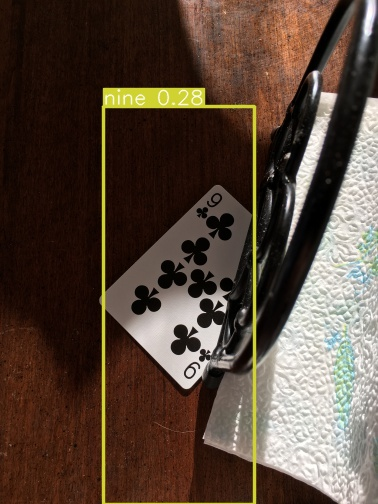

In [44]:
from IPython.display import Image, display

for imageName in glob.glob("xxx3/yyy1/*.JPG"):  # assuming JPG
        display(Image(filename=imageName))
        print("\n")